### Install Packages and Import Dataset

In this notebook, we’ll be working with a data set from the `palmerpenguins` package. This dataset contains two variables—penguin bill (A bill is another term for a bird’s beak) and flipper length (In penguins, the flipper is their equivalent of a wing.), both in millimeters—to determine whether there are distinct types of penguins in our data.

In this case, we don’t have any labels or categories already given to us. That means no one has told us what group each data point belongs to. By looking at the features of the data, like patterns or similarities, we might be able to discover new species or create our own categories based on what we find in the data.

This dataset was obtained from [kaggle](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data)

In [1]:
import numpy as np
import pandas as pd
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [3]:
# Output dataframes instead of arrays
set_config(transform_output="pandas")

#set seed for reproducibility
np.random.seed(10)

penguins = pd.read_csv("dataset/penguins.csv")
penguins

,bill_length_mm,flipper_length_mm
0,39.1,181
1,39.5,186
2,40.3,195
3,36.7,193
4,39.3,190
...,...,...
337,55.8,207
338,43.5,202
339,49.6,193
340,50.8,210


In [4]:
# Grabbing the minimum and maximum values of 'bill_length_mm' and 'flipper_length_mm'
columns_of_interest = ['bill_length_mm', 'flipper_length_mm']
min_max_values = penguins[columns_of_interest].agg(['min', 'max'])
min_max_values

,bill_length_mm,flipper_length_mm
min,32.1,172
max,59.6,231


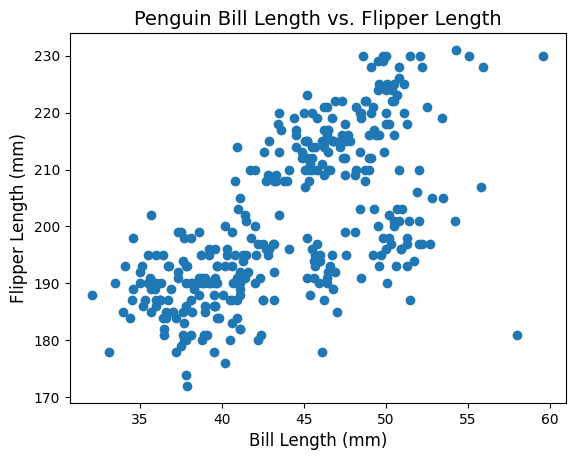

In [5]:
# Scatter plot for bill_length_mm vs flipper_length_mm
plt.scatter(penguins['bill_length_mm'], penguins['flipper_length_mm'])

# Adding labels and title
plt.title('Penguin Bill Length vs. Flipper Length', fontsize=14)
plt.xlabel('Bill Length (mm)', fontsize=12)
plt.ylabel('Flipper Length (mm)', fontsize=12)

# Display the plot
plt.show()

We will standardize our data so that prior to clustering to ensures that all features contribute equally to the distance calculations, preventing any single feature from dominating the results due to its scale.

> **Side note:**  
>  
> We will standardize our data prior to clustering to ensure that all features contribute equally to the distance calculations, preventing any single feature from dominating the results due to its scale.  
>  
> In the last notebook, we worked with a dataset of 932 real estate transactions in Sacramento, California, where we taught linear and KNN regression to predict property prices. Even though features like square footage and price had very different scales (hundreds vs. hundreds of thousands), we didn’t standardize because regression models handle these differences without impacting performance. Plus, in regression, preserving the original meaning of features—like price in dollars or size in square feet—is important for interpreting the results.  
>  
> However, in clustering, distances between data points matter. For example, features like bill length (32.1 to 59.6 mm) and flipper length (172 to 231 mm) have different ranges, and without standardization, flipper length could dominate the analysis. Standardizing ensures both features contribute equally to the grouping process, which is critical when feature ranges differ significantly, but less important when interpretation matters.

In [6]:
scaler = StandardScaler()
standardized_penguins = scaler.fit_transform(penguins)

# Convert the standardized data back to a DataFrame
standardized_penguins = pd.DataFrame(standardized_penguins, columns=penguins.columns)

standardized_penguins


,bill_length_mm,flipper_length_mm
0,-0.884499,-1.418347
1,-0.811126,-1.062250
2,-0.664380,-0.421277
3,-1.324737,-0.563715
4,-0.847812,-0.777373
...,...,...
337,2.178824,0.433355
338,-0.077396,0.077258
339,1.041543,-0.563715
340,1.261662,0.647013


### Visualizing the Data

Now, let’s create a scatter plot to visualize the relationship between the two variables and see if we can detect subtypes or groups in our data set.

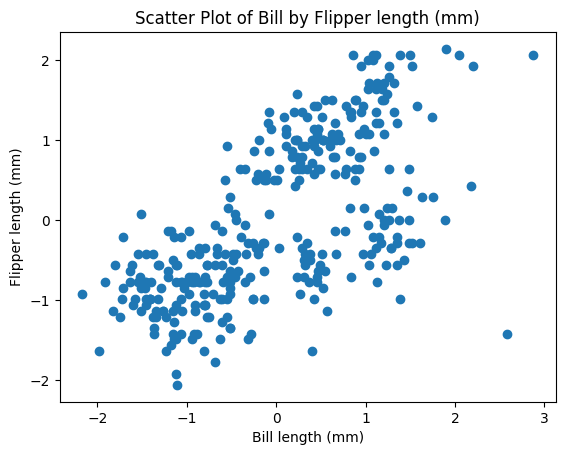

In [7]:
# Plot
plt.scatter(standardized_penguins["bill_length_mm"], standardized_penguins["flipper_length_mm"])

# Add labels and legend
plt.xlabel("Bill length (mm)")
plt.ylabel('Flipper length (mm)')
plt.title('Scatter Plot of Bill by Flipper length (mm)')
plt.show()

Based on the visualization, we might suspect there are a few subtypes of penguins within our data set. We can see roughly 3 groups of observations in Fig. 9.2, including:

1. a small flipper and bill length group,

2. a small flipper length, but large bill length group, and

3. a large flipper and bill length group.

Data visualization helps us see patterns with a few variables, but as the number of variables increases, it becomes harder to find groups. To systematically group data, we use clustering algorithms. This notebook focuses on **K-means clustering** and the **Elbow method** to choose the number of clusters, which effectively organizes data into groups.

### What is K-means Clustering?

K-means clustering is a way to group data points into **K** different groups, based on how similar or close the points are to each other. The number **K** is the number of clusters you want to find in the data. The main goal of K-means is to organize the data into clusters where the points in each cluster are close together, while points in different clusters are far apart.

In order to find these clusters, K-means performs two main steps over and over:

1. **Center Update**: It recalculates the center of each cluster by finding the average location of all the points in the cluster. The center is the "heart" of the cluster and represents the average point of that group.

2. **Label Update**: Each data point is then assigned to the nearest center (cluster). This step makes sure that every point belongs to the group with the closest center.

These two steps repeat until the centers stop moving and the points stay in the same groups. By doing this, K-means finds the best grouping of points, minimizing the distance between each point and its cluster center. This process ensures that similar points are grouped together, forming distinct clusters in the data.

#### How Does K-means Work?


To perform K-means clustering in Python, it follows a similar workflow to classification and regression tasks. 

##### **Step 1:** Create the K-means Model
To indicate that we are performing K-means clustering, we will create a KMeans model object. It takes at least one argument: the number of clusters `n_clusters`, **which we set to 5 randomly** (We'll come back to this.)

Note that the K-means algorithm uses a random initialization of assignments, but since we set the random seed in the beginning of this notebook, the clustering will be reproducible.

In [8]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit(standardized_penguins)

##### **Step 2:** Cluster visualization

The KMeans object contains useful information for visualizing and evaluating clusters. To start, you can visualize the clusters with a colored scatter plot. First, add the cluster assignments to your original penguins DataFrame using the `labels_` attribute of the KMeans object. This will help you see how the data points are grouped.

In [9]:
# Create a copy of the DataFrame for clustering and modification
standardized_penguins_with_clusters = standardized_penguins[['bill_length_mm', 'flipper_length_mm']].copy()

# Add cluster labels to the copied DataFrame
standardized_penguins_with_clusters['Cluster'] = clusters.labels_

# Display the updated DataFrame with the 'Cluster' column
standardized_penguins_with_clusters

,bill_length_mm,flipper_length_mm,Cluster
0,-0.884499,-1.418347,1
1,-0.811126,-1.062250,1
2,-0.664380,-0.421277,2
3,-1.324737,-0.563715,1
4,-0.847812,-0.777373,1
...,...,...,...
337,2.178824,0.433355,4
338,-0.077396,0.077258,2
339,1.041543,-0.563715,4
340,1.261662,0.647013,4


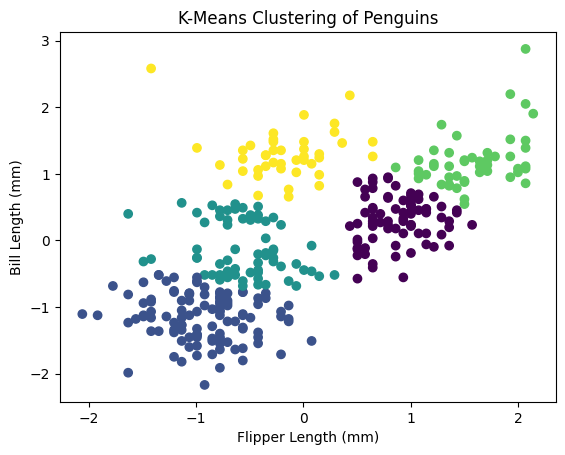

In [10]:
# Plot the clusters
plt.scatter(standardized_penguins_with_clusters['flipper_length_mm'], standardized_penguins_with_clusters['bill_length_mm'], c=standardized_penguins_with_clusters['Cluster'])
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Bill Length (mm)')
plt.title('K-Means Clustering of Penguins')
plt.show()


Great! Now we know how to Create the K-means Model and Visualize it, but...

###  How do we Choose the **Optimal** Number of Clusters (K)?

Mathematically, the WSSD (Within-Cluster Sum of Squared Distances) formula is:

$$
\text{WSSD} = \sum_{i=1}^{k} \sum_{x \in C_i} \left( \| x - \mu_i \|^2 \right)
$$

Where:
- $k$ is the number of clusters.
- $ C_i $ is the set of points in cluster $ i $.
- $ \mu_i $ is the center (mean) of cluster $ i $.
- $ \| x - \mu_i \|^2 $ is the squared distance between a data point $ x $ and the center $ \mu_i $.

To find the best number of clusters, we use the **elbow method**. This involves plotting the total WSSD against different values of $k$ and looking for an “elbow”—the point where increasing the number of clusters no longer leads to a significant reduction in WSSD.

#### Thankfully...

we don’t need to manually calculate the WSSD using the formula. In scikit-learn, the total WSSD is already stored in the `.inertia_` attribute of the KMeans object.

In [11]:
clusters.inertia_

91.47610853298526

To calculate the total WSSD for different values of $k$, we’re going to loop through several values of $k$ (the number of clusters) and run K-means for each one. We'll store the WSSD results for each $k$ in a DataFrame so we can compare them later.

In [12]:
# Initialize an empty list to store the WSSD values
wssd_list = []

# Loop through values of k from 1 to 10 (feel free to adjust this range).
for k in range(1, 10): 

    # Perform K-means clustering
    elbow_kmeans = KMeans(n_clusters=k, random_state=0)
    elbow_kmeans.fit(standardized_penguins)

    
    # Append the WSSD (inertia) to the wssd_list
    wssd_list.append(elbow_kmeans.inertia_)

# Create a DataFrame
penguin_clust_ks = pd.DataFrame({
    "k": range(1, 10),  # List of k values
    "wssd": wssd_list  # List of WSSD values from the loop
})

# Display the DataFrame
penguin_clust_ks

,k,wssd
0,1,684.000000
1,2,247.016625
2,3,157.815322
3,4,118.770529
4,5,91.476109
5,6,78.647398
6,7,73.619352
7,8,57.793880
8,9,53.405565


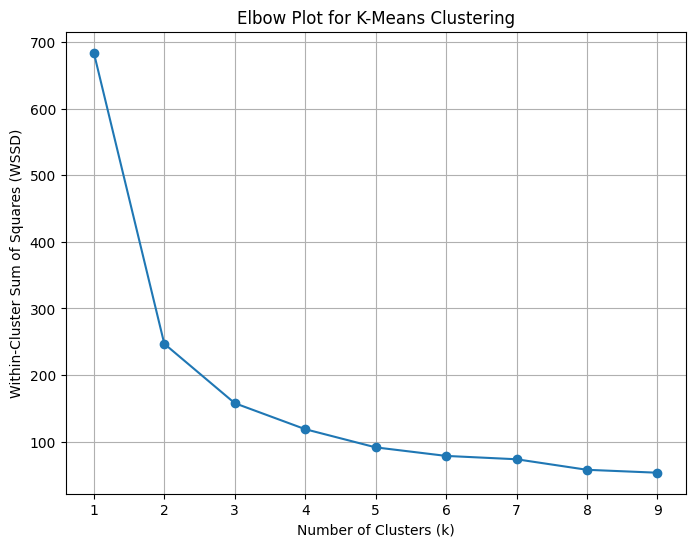

In [13]:
# Create the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(penguin_clust_ks['k'], penguin_clust_ks['wssd'], marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSSD)')
plt.title('Elbow Plot for K-Means Clustering')
plt.xticks(penguin_clust_ks['k'])  # Optional: to ensure all k values are shown on the x-axis
plt.grid(True)
plt.show()


Three clusters appear to be the best choice because the plot shows a clear "elbow" at this point. This means that adding more clusters beyond three doesn't significantly reduce the WSSD, indicating that three clusters provide a good balance between capturing the structure in the data and minimizing the WSSD without over-complicating the model.

Feel free to scroll up and change the number of clusters in the code from three to any other value. Then, re-run the rest of the code to see how different numbers of clusters affect the results.

### Conclusion

In this notebook, we worked through exploratory analyses to identify meaningful subgroups (or clusters) in the data. Here's a summary of what we covered:

1. **Scaling**: We identify when it is necessary to scale variables before clustering.
2. **K-means clustering:** We implemented k-means clustering 
3. **Visualization:** We visualized the output of K-means clustering using a colored scatter plot.
4. **Elbow method:** We used the elbow method to choose the number of clusters for K-means. 


We hope this notebook has provided a practical understanding of data clustering,  and the application of machine learning algorithms like k-means. Feel free to experiment further with the dataset or the code to enhance your learning!